Task 1: Data Filtering

In [3]:
# Install NLP and Plotting libraries
%pip install spacy nltk wordcloud seaborn matplotlib

# Download the English language model for spaCy
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay

In [5]:
import pandas as pd
import os

# --- CONFIGURATION ---
INPUT_FILE = '../../../data/weighted_score_above_08.csv' 
OUTPUT_FILE = '../../../data/filtered_reviews.csv'

print("--- TASK 1: Data Filtering Started ---")

# --- STEP 1: LOAD DATA ---
# Define columns that we mainly need to use to save memory and time
cols_to_read = [
    'language', 
    'review', 
    'voted_up', 
    'weighted_vote_score', 
    'votes_funny', 
    'steam_purchase', 
    'received_for_free', 
    'written_during_early_access', 
    'author_playtime_at_review', 
    'author_num_games_owned', 
    'author_num_reviews', 
    'game'
]

print(f"Loading {INPUT_FILE}...")

# pd.read_csv loads the specific columns into memory immediately
df = pd.read_csv(
    INPUT_FILE, 
    usecols=cols_to_read,
    dtype={
        'votes_funny': 'float',
        'weighted_vote_score': 'float',
        'author_playtime_at_review': 'float',
        'author_num_games_owned': 'float',
        'author_num_reviews': 'float',
        'voted_up': 'object'
    },
    on_bad_lines='skip' 
)

# --- STEP 2: FILTER FOR ENGLISH ---
if 'language' in df.columns:
    print(f"Initial rows: {len(df)}")
    df = df[df['language'] == 'english']
    print(f"Rows after English filter: {len(df)}")
else:
    raise ValueError("The 'language' column was not found in the dataset")

# --- STEP 3: CLEANUP TEXT ---
print("Cleaning text (removing newlines)...")
# Replace newlines/carriage returns with space
df['review'] = df['review'].str.replace(r'[\n\r]+', ' ', regex=True)
df['review'] = df['review'].str.strip()

# --- STEP 4: SELECT FINAL COLUMNS ---
# Drop language column as it is now redundant
df = df.drop(columns=['language'])

# --- STEP 5: SAVE ---
# Drop rows where review content is missing
df = df.dropna(subset=['review'])

print(f"Saving filtered data to {OUTPUT_FILE}...")
df.to_csv(OUTPUT_FILE, index=False)

print("--- Task 1 Complete :D ---")

--- TASK 1: Data Filtering Started ---
Loading ../../../data/weighted_score_above_08.csv...
Initial rows: 498094
Rows after English filter: 193174
Cleaning text (removing newlines)...
Saving filtered data to ../../../data/filtered_reviews.csv...
--- Task 1 Complete :D ---


In [6]:
# CONFIGURATION
# Establish input and output files
INPUT_FILE = '../../../data/filtered_reviews.csv'
OUTPUT_FILE = '../../../data/processed_text.csv'

# Load the English model for spaCy (lemmatization)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner']) # Disable parser/ner for speed

# Download NLTK stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Add custom stopwords specific to gaming/Steam if needed
custom_stops = {'game', 'play', 'played', 'hour', 'time', 'steam'} 
stop_words.update(custom_stops)

In [7]:
# 1. Load data and define ML problem
print(f"Loading data from {INPUT_FILE}...")
df = pd.read_csv(INPUT_FILE)

# Quick check to ensure no empty reviews slipped through
df = df.dropna(subset=['review'])
print(f"Loaded {len(df)} reviews.")

# Number of rows and columns
print(f"\nShape of Dataset: ", df.shape)
display(f"Dataframe's head: ", df.head())


# Definition
# Supervised Learning - Binary Classification Problem
# Label - Voted Up (True/False), predict whether a review is positive (voted up) or 
# negative (not voted up) based on features and text content

Loading data from ../../../data/filtered_reviews.csv...
Loaded 193166 reviews.

Shape of Dataset:  (193166, 11)


"Dataframe's head: "

,game,author_num_games_owned,author_num_reviews,author_playtime_at_review,review,voted_up,votes_funny,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
0,Counter-Strike,41.0,10.0,221.0,cs 1.6>cs2,1,13.0,0.863652,1,0,0
1,Counter-Strike,0.0,1.0,396410.0,#1 PLAYED PC GAME ONLINE SINCE 1999,1,1.0,0.865922,1,0,0
2,Counter-Strike,50.0,50.0,81.0,"best played with a membrane keyboard, a roller...",1,31.0,0.935513,1,0,0
3,Counter-Strike,11.0,5.0,78.0,My friend who I play counter-strike with said ...,1,19.0,0.875650,1,0,0
4,Counter-Strike,0.0,27.0,26568.0,Counter-Strike won't ever be canceled. Counter...,1,2.0,0.877432,1,0,0


In [8]:
# 2. Text Preprocessing Function (Lowercase, remove special characters/numbers, tokenize, lemmatize, and remove stopwords 
def preprocess_text(text):
    # Lowercase & basic cleanup via Regex
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Process with spaCy
    doc = nlp(text)
    
    # Lemmatize and filter stopwords/
    cleaned_tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_space]
    
    return " ".join(cleaned_tokens)

In [ ]:
print("Starting text preprocessing")

# Apply the function to the 'review' column
df['cleaned_review'] = df['review'].apply(preprocess_text)

print("Preprocessing complete!")
# Save Output
# Save the dataset with the new 'cleaned_review' column
df.to_csv(OUTPUT_FILE, index=False)
print(f"Saved processed data to {OUTPUT_FILE}")

Starting text preprocessing


In [ ]:
# df = pd.read_csv(OUTPUT_FILE)
df['cleaned_review'] = df['cleaned_review'].fillna('')

Generating Frequency Plot...


C:\Users\anya\AppData\Local\Temp\ipykernel_47704\3365029400.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')


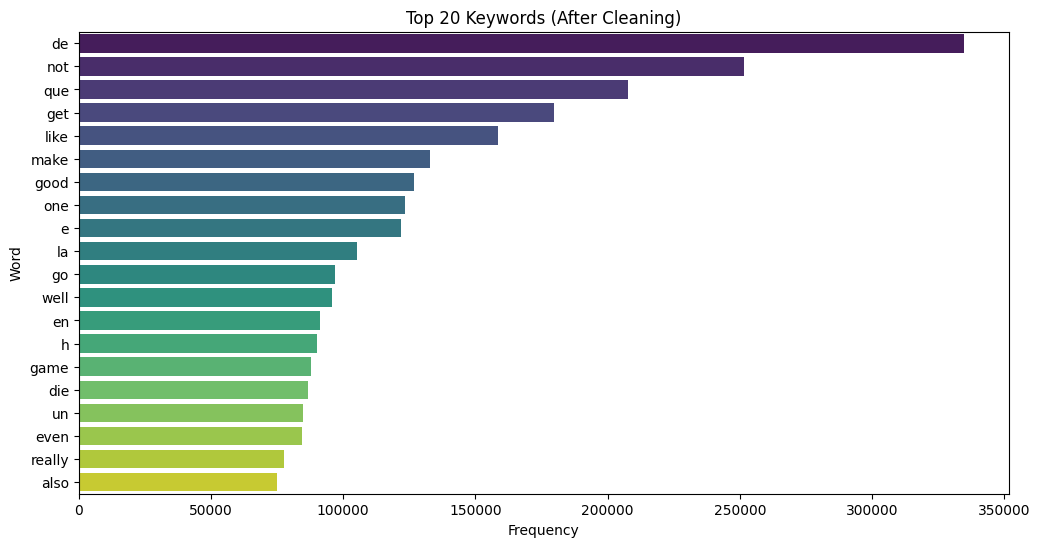

In [ ]:
# 4. Keyword Frequency Plot
print("Generating Frequency Plot...")
# Split all cleaned reviews into a giant list of words
all_words = " ".join(df['cleaned_review']).split()
word_freq = Counter(all_words)

# Get top 20 words
common_words = word_freq.most_common(20)
words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')
plt.title('Top 20 Keywords (After Cleaning)')
plt.show()

Generating Correlation Heatmap...


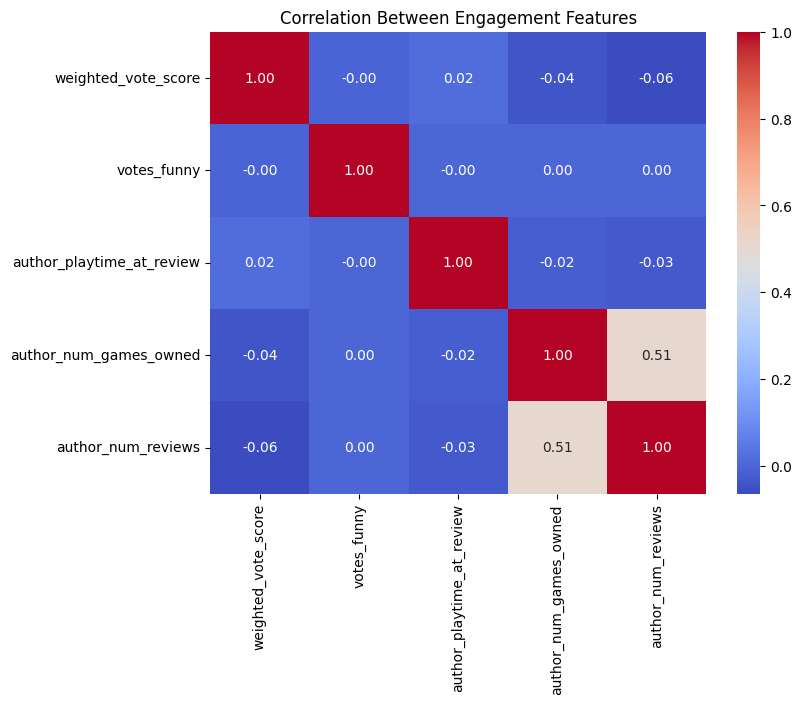

In [ ]:
# 5. Correlation Heatmap
print("Generating Correlation Heatmap...")

# Select only numerical columns for correlation
numeric_cols = [
    'weighted_vote_score', 'votes_funny', 'author_playtime_at_review', 
    'author_num_games_owned', 'author_num_reviews'
]

categorical_cols = ['language', 'steam_purchase', 'received_for_free', 'written_during_early_access']

# Calculate correlation matrix
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Engagement Features')
plt.show()

,weighted_vote_score,votes_funny,author_playtime_at_review,author_num_games_owned,author_num_reviews
count,498094.000000,4.980940e+05,4.980940e+05,498094.000000,498094.000000
mean,0.862752,1.731495e+04,8.185473e+03,416.482487,54.545507
std,0.045065,8.606345e+06,4.557393e+04,1298.240833,202.719832
min,0.800000,0.000000e+00,0.000000e+00,0.000000,1.000000
25%,0.824808,4.000000e+00,1.170000e+02,0.000000,4.000000
50%,0.854547,1.400000e+01,5.990000e+02,70.000000,13.000000
75%,0.894107,5.200000e+01,2.609000e+03,297.000000,37.000000
max,0.998141,4.294967e+09,4.776595e+06,30425.000000,10413.000000


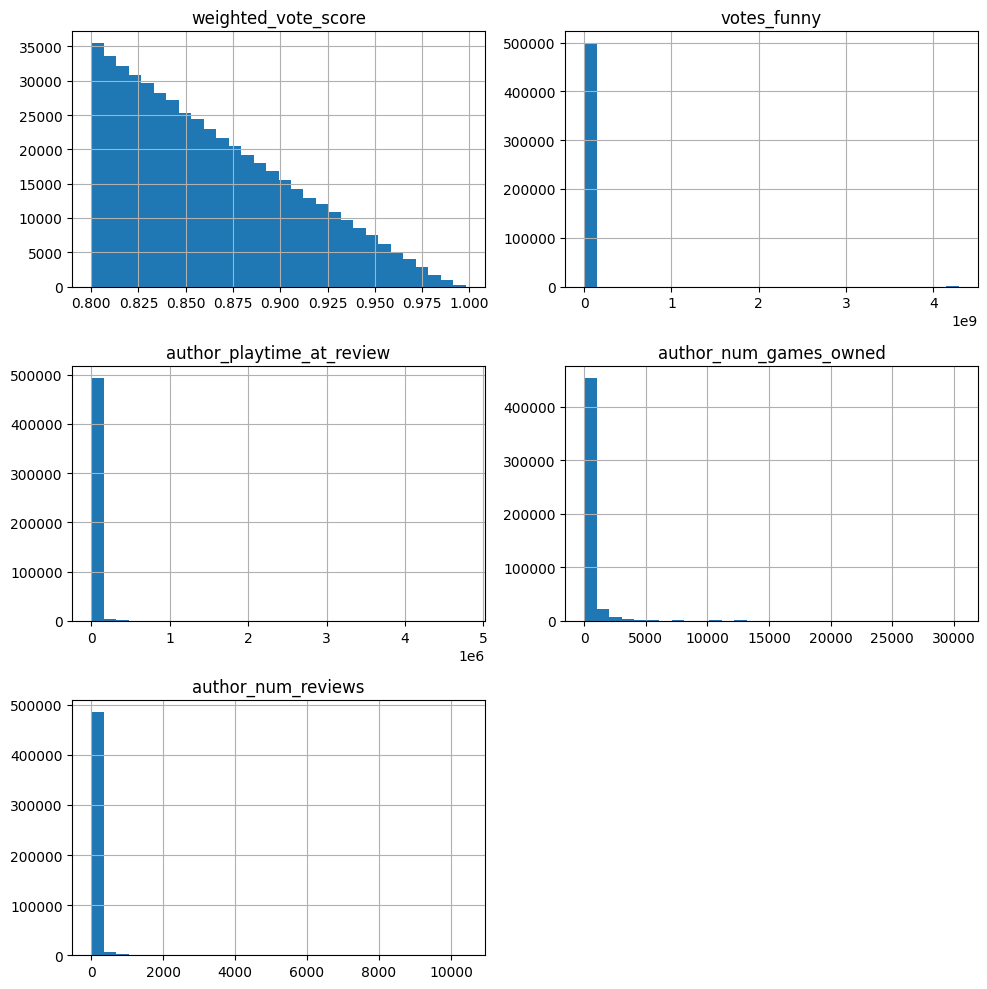

In [ ]:
# Exploratory Analysis
display(df[numeric_cols].describe())
df[numeric_cols].hist(bins=30, figsize=(10,10))
plt.tight_layout()
plt.show()

In [ ]:
# We can see that the features are all extremely right skewed with clear outliers
# Weighted_vote_score has a nice gradual right skew while every other feature has a clear tail with large outliers
# This shows a need for feature standardization

In [ ]:
# 6. Save Output
# Save the dataset with the new 'cleaned_review' column
df.to_csv(OUTPUT_FILE, index=False)
print(f"Saved processed data to {OUTPUT_FILE}")

Saved processed data to ../../../data/processed_text.csv


In [ ]:
features = ['author_playtime_at_review', 'author_num_games_owned', 'author_num_reviews', 'votes_funny', 'weighted_vote_score']

target = 'voted_up'
df[target] = df[target].astype(int)

X = df[features]
y = df[target]

In [ ]:
# imputer to handle missing data
imp = SimpleImputer(strategy='mean')
X_imp = imp.fit_transform(X)

# scale data for logistical regression
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_imp)

In [ ]:
# train data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=0)

In [ ]:
# initialize the simple models
knn = KNeighborsClassifier(n_neighbors=5)
logmodel = LogisticRegression(random_state=0)
decisiontree = DecisionTreeClassifier(random_state=0)

In [ ]:
# train models
print("Training Logistic Regression Model:")
logmodel.fit(X_train, y_train)
y_pred_log = logmodel.predict(X_test)
print("Training Decision Tree Model:")
decisiontree.fit(X_train, y_train)
y_pred_dt = decisiontree.predict(X_test)
print("Training KNN:")
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

Training Logistic Regression Model:
Training Decision Tree Model:
Training KNN:


In [ ]:
# display results
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log)}")
print(f"Precision: {precision_score(y_test, y_pred_log)}")
print(f"Recall: {recall_score(y_test, y_pred_log)}")
print(f"F1 Score: {f1_score(y_test, y_pred_log)}")
print("")
print("Decision Tree:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(f"Precision: {precision_score(y_test, y_pred_dt)}")
print(f"Recall: {recall_score(y_test, y_pred_dt)}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt)}")
print("")
print("KNN:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn)}")
print(f"Precision: {precision_score(y_test, y_pred_knn)}")
print(f"Recall: {recall_score(y_test, y_pred_knn)}")
print(f"F1 Score: {f1_score(y_test, y_pred_knn)}")

Logistic Regression:
Accuracy: 0.8451199068450798
Precision: 0.8451368742282944
Recall: 0.9999762447738503
F1 Score: 0.916059605351207

Decision Tree:
Accuracy: 0.7431614451058532
Precision: 0.8551534396664566
Recall: 0.8380487457240593
F1 Score: 0.8465146970605879

KNN:
Accuracy: 0.8221724771378954
Precision: 0.8470187820385664
Recall: 0.9636307487647282
F1 Score: 0.9015696624531185


array([[    0, 15427],
       [    2, 84190]], dtype=int64)

array([[ 3476, 11951],
       [13635, 70557]], dtype=int64)

array([[  774, 14653],
       [ 3062, 81130]], dtype=int64)

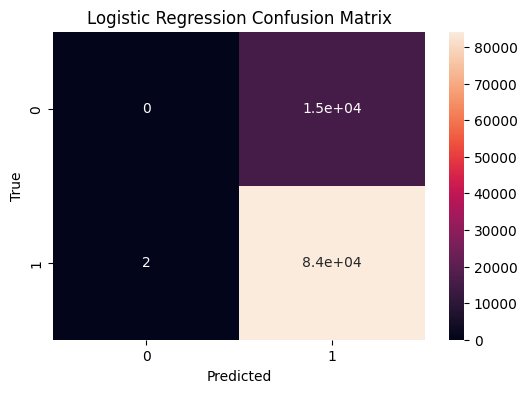

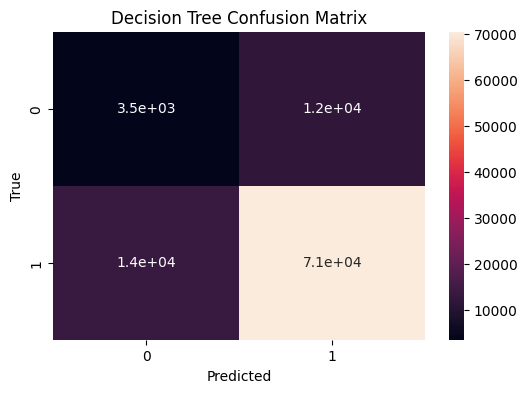

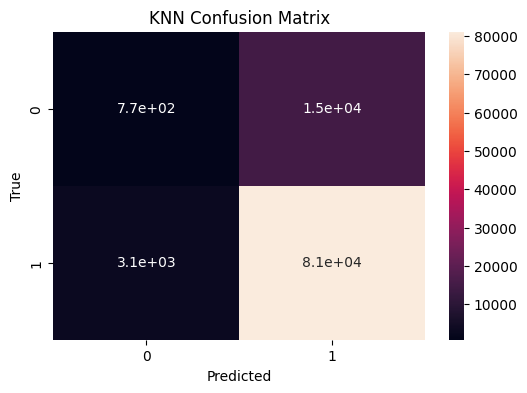

In [ ]:
# Confusion Matrices for the simple models

# Logistic Regression
display(confusion_matrix(y_test, y_pred_log));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Logistic Regression Confusion Matrix');

# Decision Tree
display(confusion_matrix(y_test, y_pred_dt));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Decision Tree Confusion Matrix');

# KNN
display(confusion_matrix(y_test, y_pred_knn));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('KNN Confusion Matrix');

In [ ]:
print(df['voted_up'].value_counts(normalize=True))
print("This shows that logistic regression just guessed 'positive' for all of the reviews.")

voted_up
1    0.844403
0    0.155597
Name: proportion, dtype: float64
This shows that logistic regression just guessed 'positive' for all of the reviews.


In [ ]:
# the more advanced models
for col in ['steam_purchase', 'received_for_free', 'written_during_early_access']:
    if col in df.columns:
        df[col] = df[col].astype(int)

X_adv = df[numeric_cols + categorical_cols +  ['cleaned_review']]
y_adv = df['voted_up'].astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_adv, y_adv, test_size=0.2, random_state=0)

In [ ]:
# numerical transformer
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
# converts text into numerical vectors
text_transformer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
# cat variables
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])
preproc = ColumnTransformer(transformers=[('num', numerical_transformer, numeric_cols), ('cat', categorical_transformer, categorical_cols), ('txt', text_transformer, 'cleaned_review')])

In [ ]:
# random forest
print("Training Random Forest: ")
randomforest = Pipeline(steps=[('preprocessor', preproc), ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state = 0, n_jobs = 1))])
randomforest.fit(X_train, y_train)
y_pred_train = randomforest.predict(X_train)
y_pred_randomforest = randomforest.predict(X_test)
print("")
print("Random Forest: ")
print(f"Training Accuracy:  {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_randomforest)}")
print(f"Precision: {precision_score(y_test, y_pred_randomforest)}")
print(f"Recall:    {recall_score(y_test, y_pred_randomforest)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_randomforest)}")

# A training accuracy of 1.0 is a clear sign of overfitting

Training Random Forest: 

Random Forest: 
Training Accuracy:  0.9999899617290922
Accuracy:  0.8682179102380068
Precision: 0.869847614289283
Recall:    0.992588369441277
F1 Score:  0.9271734788976168


In [ ]:
# optimizing random forest
X_sub, unused, y_sub, unused2 = train_test_split(X_train, y_train, train_size=10000, stratify=y_train, random_state=0)
rf_pipe = Pipeline(steps=[("preprocessor", preproc), 
                          ("classifier", RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=1))])
rf_params = {
     "classifier__n_estimators": [100, 200], 
     "classifier__max_depth": [100, 200, 300], 
     "classifier__min_samples_split": [2, 10], 
     "classifier__min_samples_leaf": [1, 5], 
     "classifier__max_features": ["sqrt", 0.5],
}

rf_grid = GridSearchCV(rf_pipe, param_grid=rf_params, scoring="accuracy", cv=3, n_jobs=-1)
rf_grid.fit(X_sub, y_sub)

rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_pred_train = rf_best.predict(X_train)
rf_prob = rf_best.predict_proba(X_test)[:, 1]

print("Random Forest Optimized: ")
print(f"Training Accuracy:  {accuracy_score(y_train, rf_pred_train)}")
print(f"Accuracy:  {accuracy_score(y_test, rf_pred)}")
print(f"Precision: {precision_score(y_test, rf_pred)}")
print(f"Recall:    {recall_score(y_test, rf_pred)}")
print(f"F1 Score:  {f1_score(y_test, rf_pred)}")

# Accuracy is weaker than default parameters

Random Forest Optimized: 
Training Accuracy:  0.8569772256728778
Accuracy:  0.8549875023840834
Precision: 0.8629503965362919
Recall:    0.9848204104903079
F1 Score:  0.919866425552215


In [ ]:
# gradient boosting

print("Training Gradient Boosting: ")
gradientboosting = Pipeline(steps=[('preprocessor', preproc), ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=0))])
gradientboosting.fit(X_train, y_train)
y_pred_gradientboosting = gradientboosting.predict(X_test)
y_pred_train = gradientboosting.predict(X_train)
print("")
print("Gradient Boosting: ")
print(f"Training Accuracy:  {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_gradientboosting)}")
print(f"Precision: {precision_score(y_test, y_pred_gradientboosting)}")
print(f"Recall:    {recall_score(y_test, y_pred_gradientboosting)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_gradientboosting)}")

Training Gradient Boosting: 

Gradient Boosting: 
Training Accuracy:  0.8625760712717234
Accuracy:  0.8621548098254349
Precision: 0.8627396470418649
Recall:    0.9952370771569745
F1 Score:  0.9242639840277088


In [ ]:
# optimizing gradient boosting

gb_pipe = Pipeline(steps=[("preprocessor", preproc), 
                          ("classifier", GradientBoostingClassifier(random_state=0))])
gb_params = {
     "classifier__n_estimators": [100, 200], 
     "classifier__learning_rate": [.01, .05, .1], 
     "classifier__max_depth": [3, 5], 
     "classifier__subsample": [.8, 1]
}

gb_grid = GridSearchCV(gb_pipe, param_grid=gb_params, scoring="f1", cv=3, n_jobs=-1)
gb_grid.fit(X_sub, y_sub)

gb_best = gb_grid.best_estimator_
gb_pred = gb_best.predict(X_test)
gb_pred_train = gb_best.predict(X_train)
gb_prob = gb_best.predict_proba(X_test)[:, 1]

print("Gradient Boosting optimized: ")
print(f"Training Accuracy:  {accuracy_score(y_train, gb_pred_train)}")
print(f"Accuracy:  {accuracy_score(y_test, gb_pred)}")
print(f"Precision: {precision_score(y_test, gb_pred)}")
print(f"Recall:    {recall_score(y_test, gb_pred)}")
print(f"F1 Score:  {f1_score(y_test, gb_pred)}")

Gradient Boosting optimized: 
Training Accuracy:  0.8583123157036201
Accuracy:  0.858561117859043
Precision: 0.8604883166035873
Recall:    0.9937642531356898
F1 Score:  0.9223366258047447


In [ ]:
# adaboost
adaboost = Pipeline(steps=[('preprocessor', preproc), ('classifier', AdaBoostClassifier(n_estimators=50, random_state=0))])
print("Training AdaBoost: ")
adaboost.fit(X_train, y_train)
y_pred_adaboost = adaboost.predict(X_test)
print("")
print("Ada Boosting: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_adaboost)}")
print(f"Precision: {precision_score(y_test, y_pred_adaboost)}")
print(f"Recall:    {recall_score(y_test, y_pred_adaboost)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_adaboost)}")

Training AdaBoost: 

Ada Boosting: 
Accuracy:  0.8464048022967506
Precision: 0.8464191968461174
Recall:    0.9996436716077537
F1 Score:  0.9166725663716814


In [ ]:
# support vector machine
svm_model = Pipeline(steps=[('preprocessor', preproc), ('classifier', LinearSVC(C=1.0, random_state=0, dual='auto'))])
print("Training Linear SVM: ")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("")
print("Linear SVM: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_svm)}")
print(f"Precision: {precision_score(y_test, y_pred_svm)}")
print(f"Recall:    {recall_score(y_test, y_pred_svm)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_svm)}")

Training Linear SVM: 

Linear SVM: 
Accuracy:  0.8798120840401932
Precision: 0.8876947358249498
Recall:    0.9820291714177118
F1 Score:  0.9324821943145869


In [ ]:
# neural network
nn= Pipeline(steps=[('preprocessor', preproc), ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=0))])
print("Training Neural Network: ")
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
print("")
print("Neural Network: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_nn)}")
print(f"Precision: {precision_score(y_test, y_pred_nn)}")
print(f"Recall:    {recall_score(y_test, y_pred_nn)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_nn)}")

Training Neural Network: 

Neural Network: 
Accuracy:  0.8682580632208715
Precision: 0.8967885298255801
Recall:    0.9539029836564044
F1 Score:  0.9244644481024024


array([[ 2923, 12504],
       [  624, 83568]], dtype=int64)

array([[ 2096, 13331],
       [  401, 83791]], dtype=int64)

array([[  156, 15271],
       [   30, 84162]], dtype=int64)

array([[ 4967, 10460],
       [ 1513, 82679]], dtype=int64)

array([[ 6184,  9243],
       [ 3881, 80311]], dtype=int64)

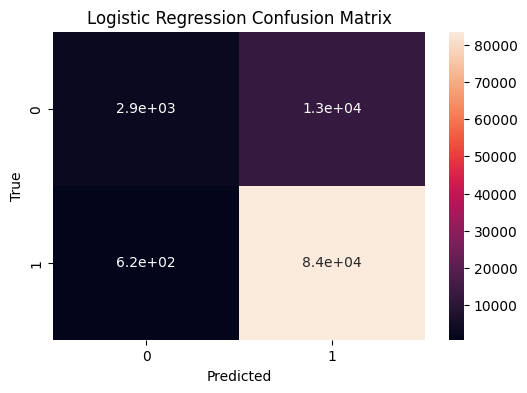

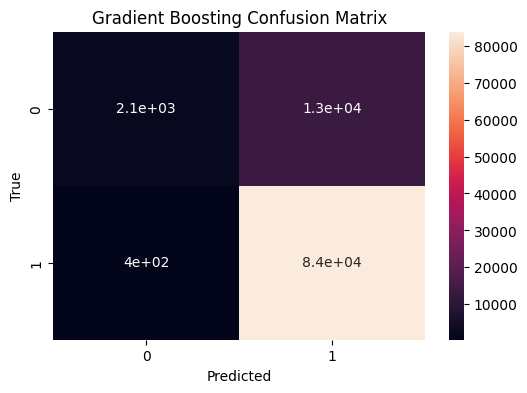

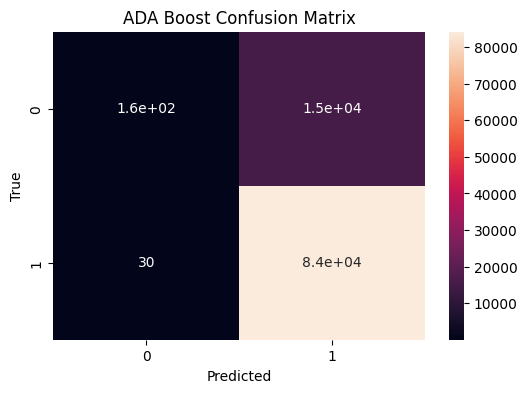

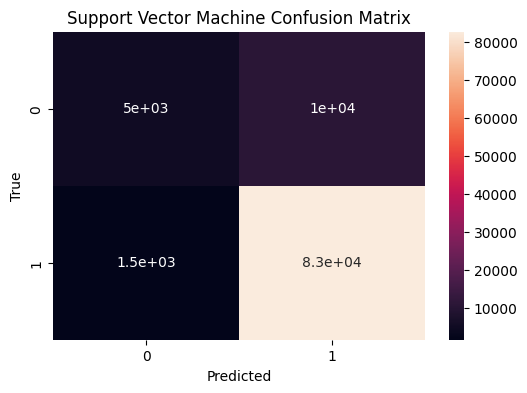

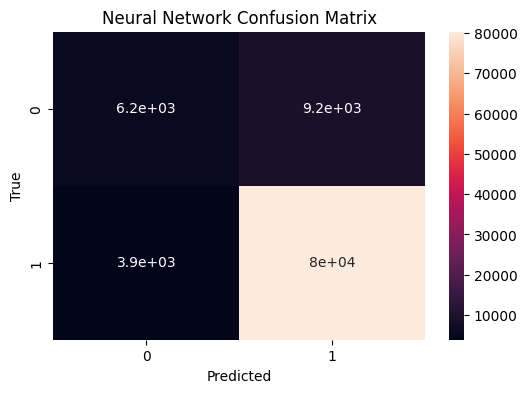

In [ ]:
# Confusion Matrices for the complex models

# Random Forest
display(confusion_matrix(y_test, y_pred_randomforest));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_randomforest), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Logistic Regression Confusion Matrix');

# Gradient Boosting
display(confusion_matrix(y_test, y_pred_gradientboosting));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_gradientboosting), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Gradient Boosting Confusion Matrix');

# ADA Boost
display(confusion_matrix(y_test, y_pred_adaboost));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_adaboost), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('ADA Boost Confusion Matrix');

# Support Vector Machines
display(confusion_matrix(y_test, y_pred_svm));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Support Vector Machine Confusion Matrix');

# Neural Network
display(confusion_matrix(y_test, y_pred_nn));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Neural Network Confusion Matrix');

In [ ]:
# Ada Boost Optimization

ada_pipe = Pipeline(steps=[
    ("preprocessor", preproc),
    ("classifier", AdaBoostClassifier(random_state=0))
])

ada_param = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__learning_rate":[0.01, 0.1, 1.0]
}

ada_grid = GridSearchCV(
    ada_pipe,
    param_grid=ada_param,
    scoring="f1", 
    cv=3,
    n_jobs=-1
)

ada_grid.fit(X_sub, y_sub)

print("Best AdaBoost Parameters: ", ada_grid.best_params_)

ada_pred = ada_grid.best_estimator_.predict(X_test)
ada_prob = ada_grid.best_estimator_.predict_proba(X_test)[:, 1] # ROC

Best AdaBoost Parameters:  {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}


In [ ]:
# SVM Optimization

svm_pipe = Pipeline(steps=[
    ("preprocessor", preproc),
    ("classifier", LinearSVC(dual="auto"))
])

svm_param = {
    "classifier__C": [0.01, 0.1, 1, 5]
}

svm_grid = GridSearchCV(
    svm_pipe, 
    param_grid=svm_param, 
    cv=3, 
    scoring="f1", 
    n_jobs=-1
)

svm_grid.fit(X_sub, y_sub)

print("Best SVM Parameters: ", svm_grid.best_params_)

svm_pred = svm_grid.best_estimator_.predict(X_test)
svm_prob = svm_grid.best_estimator_.decision_function(X_test)

Best SVM Parameters:  {'classifier__C': 0.1}


In [ ]:
# Neural Network Optimization

nn_pipe = Pipeline(steps=[
    ("preprocessor", preproc),
    ("classifier", MLPClassifier(max_iter=300, random_state=0))
])

nn_param = {
    "classifier__hidden_layer_sizes": [(50,), (100,), (100, 50)],
    "classifier__alpha": [0.001, 0.01, 0.1],
    "classifier__learning_rate_init": [0.001, 0.01]
}

nn_grid = GridSearchCV(
    nn_pipe, 
    param_grid=nn_param,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

nn_grid.fit(X_sub, y_sub)

print("Best NN Parameters: ", nn_grid.best_params_)

nn_pred = nn_grid.best_estimator_.predict(X_test)
nn_prob = nn_grid.best_estimator_.predict_proba(X_test)[:,1]

Best NN Parameters:  {'classifier__alpha': 0.1, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate_init': 0.01}


AdaBoost: 
Precision: 0.8451654352714424
Recall: 1.0
F1 Score: 0.9160863509749304

Linear SVM: 
Precision: 0.8607042340325
Recall: 0.9952608323831242
F1 Score: 0.923104888017362

Neural Network
Precision: 0.8828439084076211
Recall: 0.9598536678069175
F1 Score: 0.9197395975598652

Random Forest: 
Precision: 0.8629503965362919
Recall: 0.9848204104903079
F1 Score: 0.919866425552215

Gradient Boosting
Precision: 0.8604883166035873
Recall: 0.9937642531356898
F1 Score: 0.9223366258047447


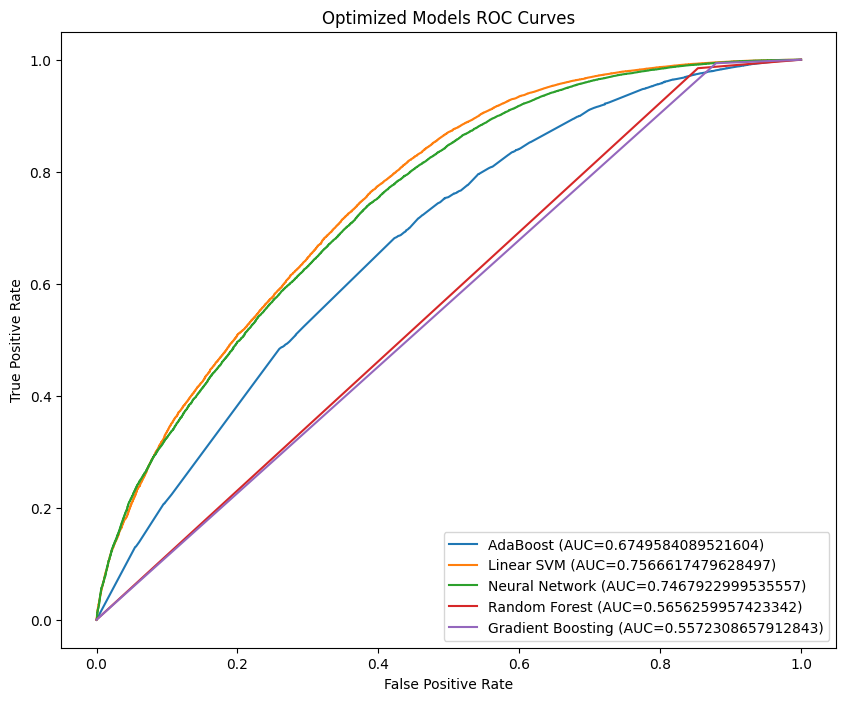


AUC Scores: 
AdaBoost AUC: 0.6749584089521604
SVM AUC: 0.7566617479628497
NN AUC: 0.7467922999535557
Random Forest AUC: 0.5656259957423342
Gradient Boosting AUC: 0.5572308657912843


In [ ]:
# Precision, Recall, F1

def display_prf(name, y_t, y_pred):
    print(name)
    print(f"Precision: {precision_score(y_t, y_pred)}")
    print(f"Recall: {recall_score(y_t, y_pred)}")
    print(f"F1 Score: {f1_score(y_t, y_pred)}")

display_prf("AdaBoost: ", y_test, ada_pred)
display_prf("\nLinear SVM: ", y_test, svm_pred)
display_prf("\nNeural Network", y_test, nn_pred)
display_prf("\nRandom Forest: ", y_test, rf_pred)
display_prf("\nGradient Boosting", y_test, gb_pred)

# ROC Curves

plt.figure(figsize=(10, 8))

# Adaboost ROC
ada_f, ada_t, _ =  roc_curve(y_test, ada_prob)
ada_auc = roc_auc_score(y_test, ada_prob)
plt.plot(ada_f, ada_t, label=f"AdaBoost (AUC={ada_auc})")

# svm ROC
svm_f, svm_t, _ = roc_curve(y_test, svm_prob)
svm_auc = roc_auc_score(y_test, svm_prob)
plt.plot(svm_f, svm_t, label=f"Linear SVM (AUC={svm_auc})")

# nn ROC
nn_f, nn_t, _ = roc_curve(y_test, nn_prob)
nn_auc = roc_auc_score(y_test, nn_prob)
plt.plot(nn_f, nn_t, label=f"Neural Network (AUC={nn_auc})")

# Random Forest ROC
rf_f, rf_t, _ =  roc_curve(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred)
plt.plot(rf_f, rf_t, label=f"Random Forest (AUC={rf_auc})")

# Gradient Boosting ROC
gb_f, gb_t, _ =  roc_curve(y_test, gb_pred)
gb_auc = roc_auc_score(y_test, gb_pred)
plt.plot(gb_f, gb_t, label=f"Gradient Boosting (AUC={gb_auc})")

plt.title("Optimized Models ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print("\nAUC Scores: ")
print(f"AdaBoost AUC: {ada_auc}")
print(f"SVM AUC: {svm_auc}")
print(f"NN AUC: {nn_auc}")
print(f"Random Forest AUC: {rf_auc}")
print(f"Gradient Boosting AUC: {gb_auc}")